In [1]:
import pandas as pd
import numpy as np
from scipy.stats import kendalltau, chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("drug_consumption.csv")

# variable categorization
all_vars = df.columns.tolist()
nominal_vars = ['gender', 'country', 'ethnicity']
ordinal_vars = ['age', 'education', 'alcohol', 'amphet', 'amyl', 'benzos', 'caff', 'cannabis', 
    'choc', 'coke', 'crack', 'ecstasy', 'heroin', 'ketamine', 'legalh', 'lsd', 'meth', 
    'mushrooms', 'nicotine', 'semer', 'vsa']
numeric_vars = ['n_score', 'e_score', 'o_score', 'a_score', 'c_score',
    'impulsive_bis11', 'sensation_seeking_impss']

# handle CL[1-9] values used to indicate recency of drug use
drug_class_map = {
    'CL0': 0, 'CL1': 1, 'CL2': 2, 'CL3': 3,
    'CL4': 4, 'CL5': 5, 'CL6': 6,
}
drug_vars = ['alcohol', 'amphet', 'amyl', 'benzos', 'caff', 'cannabis', 
    'choc', 'coke', 'crack', 'ecstasy', 'heroin', 'ketamine', 'legalh', 
    'lsd', 'meth', 'mushrooms', 'nicotine', 'semer', 'vsa']
for drug in drug_vars:
    df[drug] = df[drug].map(drug_class_map)

In [2]:
# correlation functions

# cramer's v (nominal-nominal)
# https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792
def cramers_v_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.values.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

def cramers_v(a, b):
    confusion_matrix = pd.crosstab(a, b)
    return cramers_v_stat(confusion_matrix)

def correlation_ratio(categories, measurements):
    categories = pd.Categorical(categories)
    cat_num = len(categories.categories)
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i, cat in enumerate(categories.categories):
        cat_measures = measurements[categories == cat]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.mean(cat_measures) if len(cat_measures) > 0 else 0
    y_total_avg = np.sum(y_avg_array * n_array) / np.sum(n_array)
    numerator = np.sum(n_array * (y_avg_array - y_total_avg) ** 2)
    denominator = np.sum((measurements - y_total_avg) ** 2)
    if denominator == 0:
        return 0.0
    else:
        return np.sqrt(numerator / denominator)

Strongest correlation (+/-): 
Variable 1: Lsd
Variable 2: Mushrooms 
Value: 0.625


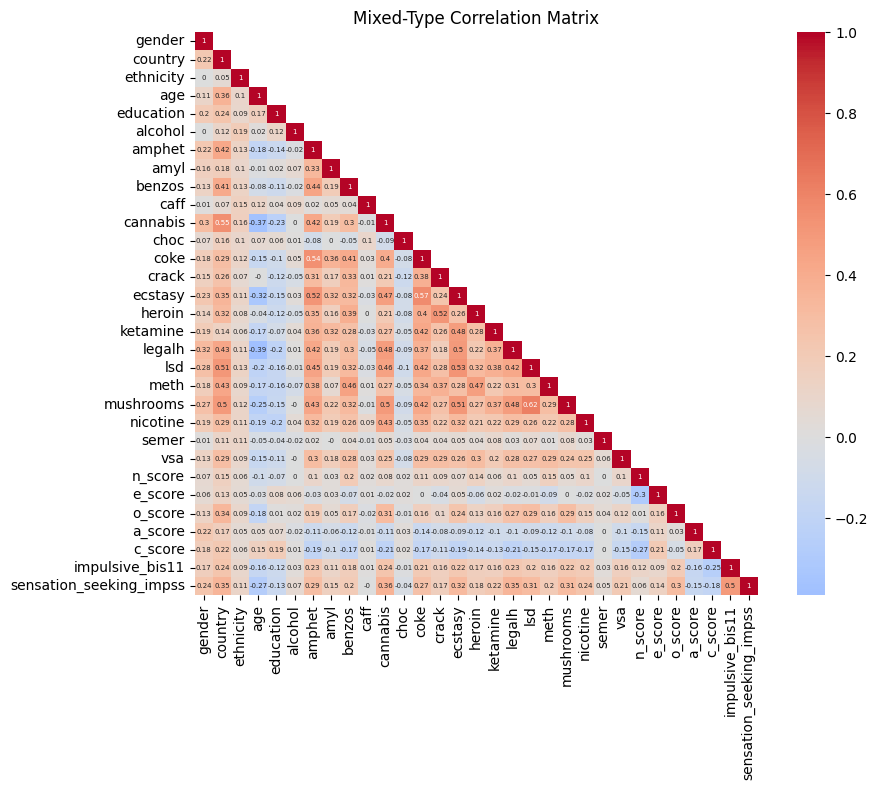

In [21]:
from numpy import absolute


matrix_vars = nominal_vars + ordinal_vars + numeric_vars
corr_matrix = pd.DataFrame(np.nan, index=matrix_vars, columns=matrix_vars)
strong_c = 0
var_s1 = var_s2 = ""
for i, var1 in enumerate(matrix_vars):
    for j, var2 in enumerate(matrix_vars):
        if i > j:
            continue  # Fill upper triangle only
        if var1 == var2:
            corr_matrix.loc[var1, var2] = 1.0
        elif var1 in numeric_vars and var2 in numeric_vars: # Use Kendall's tau for numeric-numeric
            tau, _ = kendalltau(df[var1], df[var2])
            corr_matrix.loc[var2, var1] = tau
            if np.abs(tau) > strong_c:
                strong_c = tau
                var_s1, var_s2 = var1, var2
        elif (var1 in numeric_vars and var2 in ordinal_vars) or (var2 in numeric_vars and var1 in ordinal_vars):    # Use Kendall's tau for numeric-ordinal
            tau, _ = kendalltau(df[var1], df[var2])
            corr_matrix.loc[var2, var1] = tau
            if np.abs(tau) > strong_c:
                strong_c = tau
                var_s1, var_s2 = var1, var2
        elif var1 in ordinal_vars and var2 in ordinal_vars: # Use Kendall's tau for ordinal-ordinal
            tau, _ = kendalltau(df[var1], df[var2])
            corr_matrix.loc[var2, var1] = tau
            if np.abs(tau) > strong_c:
                strong_c = tau
                var_s1, var_s2 = var1, var2
        elif var1 in nominal_vars and var2 in nominal_vars: # Use Cramér's V for nominal-nominal
            v = cramers_v(df[var1], df[var2])
            corr_matrix.loc[var2, var1] = v
            if np.abs(v) > strong_c:
                strong_c = v
                var_s1, var_s2 = var1, var2
        else:   # Mixed: nominal with numeric or ordinal (use correlation ratio)
            if var1 in nominal_vars:
                eta = correlation_ratio(df[var1], df[var2])
            else:
                eta = correlation_ratio(df[var2], df[var1])
            corr_matrix.loc[var2, var1] = eta
            if np.abs(eta) > strong_c:
                strong_c = eta
                var_s1, var_s2 = var1, var2


corr_matrix = corr_matrix.round(2)
print(f"Strongest correlation (+/-): \nVariable 1: {var_s1.title()}\nVariable 2: {var_s2.title()} \nValue: {strong_c:.3f}")
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, annot_kws={"fontsize": 5}, cmap="coolwarm", center=0, square=True)
plt.title("Mixed-Type Correlation Matrix")
plt.tight_layout()
plt.show()

In [ ]:
# Correlation Matrix Interpretation
# 1. There're no feature pairs with near-perfect correlation 
#    (abs[corr] >= 0.8), so we shouldn't drop features 
#    to avoid redundancy. Moreover, no features have an 
#    extremely strong relationship with many others, so we 
#    can/should keep most/all features.
# 2. Linear models will not generate great results with these
#    features, so we should progress as advised in lecture to
#    use tree-based or other non-linear models.